In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Neural Network Baseline
Traditional, simple neural network model with no NAICS input

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_scaled_all.parquet'))

In [8]:
business_data.describe()

,target,dset_naics_holdout,menc_NAICS,cenc_NAICS,NS___Accommodation and Food Services,NS___Administrative and Support and Waste Management and Remediation Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),...,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag,NAICS,NAICS_alt,NAICS_alt3,NAICS_alt4
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,...,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.203011,0.094541,0.204562,0.007265,0.097958,0.047133,0.095606,0.079398,0.096843,0.103658,...,-0.444129,0.705279,-0.899352,-0.985316,-0.997529,-0.602849,701.045842,767.921227,769.528095,769.233577
std,0.402241,0.292580,0.092889,0.010443,0.297258,0.211922,0.294051,0.270359,0.295744,0.304816,...,0.895963,0.708930,0.437226,0.170743,0.070251,0.797856,383.284385,326.131581,324.361889,326.453771
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.135617,0.000718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,436.000000,651.000000,644.000000,638.000000
50%,0.000000,0.000000,0.204655,0.003056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,756.000000,844.000000,825.000000,825.000000
75%,0.000000,0.000000,0.255489,0.009309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1031.000000,1034.000000,1034.000000,1034.000000
max,1.000000,1.000000,1.000000,0.044873,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1166.000000,1166.000000,1166.000000,1166.000000


In [9]:
with open(Path(setup.temp_path).joinpath('10_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [10]:
features = [f for f in imputer_features if 'NAICS' not in f]
print(features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


##### Datasets for train, validation

In [11]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + features].set_index('LoanNr_ChkDgt').sort_index()

In [12]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (436120, 10), y:(436120,)


In [13]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (93454, 10), y:(93454,)


In [14]:
base_thresh = y_train.mean()
print(base_thresh)

0.2046546821975603


## Function to create model

In [15]:
def create_model(n_feat = len(features), 
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(n_feat,), activation=activation))
    for i in range(1, n_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_size[i], input_shape=(hidden_size[i-1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [16]:
this_model = create_model()

2024-03-16 14:32:28.204732: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-16 14:32:28.204757: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-16 14:32:28.204764: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-16 14:32:28.204801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 14:32:28.204818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
this_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
this_history = this_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-03-16 14:32:28.829154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - ETA: 0s - loss: 0.4756 - auc: 0.3053 - auc_1: 0.6703

2024-03-16 14:35:35.057260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13629/13629 [==============================] - 210s 15ms/step - loss: 0.4756 - auc: 0.3053 - auc_1: 0.6703 - val_loss: 0.4725 - val_auc: 0.3300 - val_auc_1: 0.6866
Epoch 2/20
13629/13629 [==============================] - 187s 14ms/step - loss: 0.4687 - auc: 0.3221 - auc_1: 0.6855 - val_loss: 0.4710 - val_auc: 0.3360 - val_auc_1: 0.6929
Epoch 3/20
13629/13629 [==============================] - 186s 14ms/step - loss: 0.4674 - auc: 0.3266 - auc_1: 0.6891 - val_loss: 0.4697 - val_auc: 0.3406 - val_auc_1: 0.6949
Epoch 4/20
13629/13629 [==============================] - 186s 14ms/step - loss: 0.4669 - auc: 0.3288 - auc_1: 0.6905 - val_loss: 0.4686 - val_auc: 0.3418 - val_auc_1: 0.6958
Epoch 5/20
13629/13629 [==============================] - 186s 14ms/step - loss: 0.4665 - auc: 0.3296 - auc_1: 0.6912 - val_loss: 0.4682 - val_auc: 0.3427 - val_auc_1: 0.6965
Epoch 6/20
13629/13629 [==============================] - 551s 40ms/step - loss: 0.4663 - auc: 0.3307 - auc_1: 0.6918 - val_loss: 0.4682

In [19]:
this_history_df = pd.DataFrame(this_history.history)

In [20]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [21]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [22]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('11_REPORT_fit_history.csv'))

<Axes: >

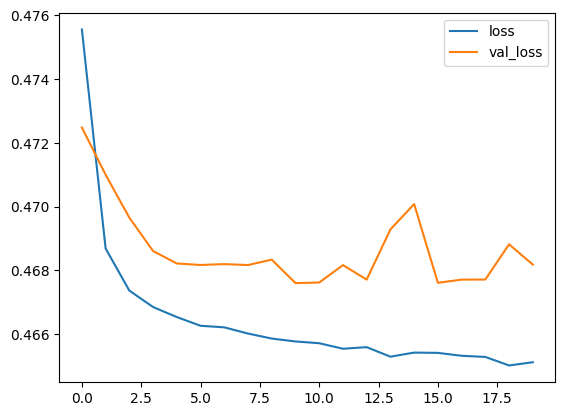

In [23]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

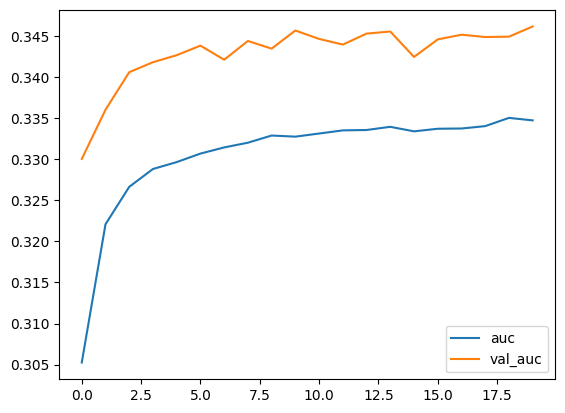

In [24]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

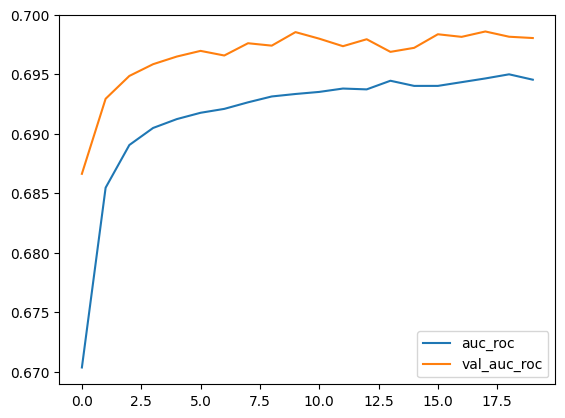

In [25]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [26]:
this_model.save(Path(setup.temp_path).joinpath('11_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [27]:
all_predictions = this_model.predict(X.drop(columns='dset'))

   96/21503 [..............................] - ETA: 34s

2024-03-16 17:06:43.394254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 32s 2ms/step


In [28]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']], on='LoanNr_ChkDgt')
    

In [29]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.282096
target,0.282096,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [30]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [31]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [32]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
9,0.18,0.428223
10,0.20,0.428189
11,0.22,0.427237


In [33]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.18

##### Append binary predictions to probability predictions

In [34]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [35]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.531993
0    0.468007
Name: proportion, dtype: float64

In [36]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('11_DATA_predictions.parquet'))

## Metrics

In [37]:
all_predictions_df = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_predictions.parquet'))

In [38]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('11_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.589873,0.426525,0.293692,0.778733,0.343701,0.712190,NaN
1,train,0.576830,0.428223,0.295948,0.774296,0.342122,0.699777,NaN
2,val,0.575032,0.429489,0.297652,0.770964,0.346262,0.698177,NaN
0,test,0.576994,0.430850,0.297860,0.778390,0.343516,0.700443,0.0
1,test,0.608375,0.419681,0.287166,0.779291,0.344602,0.728409,1.0


## Embeddings
Save the hidden layer weight prior to sigmoid output, for possible later use in unsupervised GNN 

In [39]:
embed_model = Model(inputs=this_model.inputs, outputs=this_model.layers[-2].output) 

In [40]:
embed_out = embed_model.predict(X.drop(columns='dset'))

  142/21503 [..............................] - ETA: 22s

2024-03-16 17:07:37.316375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 21s 966us/step


In [41]:
embed_out.shape

(688081, 64)

In [42]:
embed_df = pd.DataFrame(embed_out, index=X.index) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df.reset_index(inplace=True)

In [43]:
embed_df.head()

,LoanNr_ChkDgt,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,...,emb_054,emb_055,emb_056,emb_057,emb_058,emb_059,emb_060,emb_061,emb_062,emb_063
0,1000014003,0.832089,-0.834227,-0.998244,-1.000000,0.999998,0.980338,-1.000000,-1.0,0.998918,...,0.983196,0.998866,-0.999991,0.997050,-0.935856,-0.999984,-0.992986,-0.999997,0.999999,0.507023
1,1000024006,0.472593,-0.897564,-0.992873,-0.999999,0.999979,0.995357,-0.999990,-1.0,0.999952,...,0.270417,0.997277,-0.999999,0.990563,-0.298727,-0.999995,-0.970888,-0.999997,0.999925,0.498387
2,1000034009,0.985339,-0.948866,-0.999991,-1.000000,0.999981,0.749175,-1.000000,-1.0,-0.994905,...,-0.750510,0.990907,-0.301094,0.999982,0.996336,0.590655,-0.998752,-1.000000,1.000000,-0.219872
3,1000084002,0.993492,-0.913145,-0.999993,-1.000000,0.999993,0.454324,-1.000000,-1.0,-0.999608,...,0.019987,0.992956,0.686297,0.999991,0.985304,0.646742,-0.999459,-1.000000,1.000000,-0.382541
4,1000094005,-0.032632,-0.917906,-0.990496,-0.999999,0.999959,0.991775,-0.999991,-1.0,0.999968,...,-0.214682,0.993343,-0.999999,0.966676,-0.028165,-0.999994,-0.942984,-0.999998,0.999836,0.503529


In [44]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('11_DATA_embeddings.parquet'))